In [ ]:
import os
import json
import sys
import time
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

# Ensure project root is on sys.path so `utils` can be imported
cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    project_root = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    project_root = cwd
elif (cwd / "cifar10_project").is_dir():
    project_root = cwd / "cifar10_project"
else:
    project_root = None

if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from utils.ml_utils import (
    evaluate_and_log_model,
    format_duration,
    predict_and_resolve_labels,
    compute_confusion_matrix,
    build_classification_report,
    plot_confusion_matrix_notebook01,
    plot_training_curves_notebook01,
)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU(s) detectada(s): {len(gpus)}")
else:
    print("Nenhuma GPU detectada. A correr em CPU.")

2026-02-18 23:13:37.363121: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-18 23:13:37.603426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-18 23:13:38.326518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU(s) detectada(s): 1


2026-02-18 23:13:39.052420: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-18 23:13:39.147382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-18 23:13:39.147419: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Load the processed data (local project paths)
PROJECT_ROOT = os.getcwd()
if os.path.basename(PROJECT_ROOT).lower() == 'notebooks':
    PROJECT_ROOT = os.path.dirname(PROJECT_ROOT)
elif os.path.basename(PROJECT_ROOT).lower() != 'cifar10_project':
    candidate = os.path.join(PROJECT_ROOT, 'cifar10_project')
    if os.path.isdir(candidate):
        PROJECT_ROOT = candidate

DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
REPORTS_DIR = os.path.join(PROJECT_ROOT, 'reports')
LOGS_ROOT = os.path.join(REPORTS_DIR, 'logs')

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(LOGS_ROOT, exist_ok=True)

data_path = os.path.join(PROCESSED_DIR, 'cifar10_processed.npz')
data = np.load(data_path)
x_train = data["x_train"]
y_train = data["y_train"]
x_val   = data["x_val"]
y_val   = data["y_val"]
x_test  = data["x_test"]
y_test  = data["y_test"]

print('Data path:', data_path)

Data path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/processed/cifar10_processed.npz


In [3]:
log_dir = os.path.join(LOGS_ROOT, pd.Timestamp.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)

In [4]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

batch_size = 64

train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    x_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow(
    x_test, y_test,
    batch_size=batch_size,
    shuffle=False
)


# Creating, compiling and training the CNN base model

In [5]:
num_classes = 10

model = models.Sequential([
    # Block 1
    Input(shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Classifier
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


2026-02-18 23:13:41.051499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-18 23:13:41.051572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-18 23:13:41.051593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-18 23:13:41.174372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-18 23:13:41.174413: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,538 (2.54 MB)

 Trainable params: 666,538 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
learning_rate = 1e-3

model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


In [7]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
)


In [8]:
epochs = 50

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1,
)


Epoch 1/50


I0000 00:00:1771456422.751541   22583 service.cc:145] XLA service 0x73c864010fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771456422.751581   22583 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2026-02-18 23:13:42.783686: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-18 23:13:42.948515: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 16/625 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.0914 - loss: 2.3108 

I0000 00:00:1771456427.715272   22583 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.2988 - loss: 1.8698 - val_accuracy: 0.4286 - val_loss: 1.5318 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4482 - loss: 1.5012 - val_accuracy: 0.5211 - val_loss: 1.3206 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5197 - loss: 1.3334 - val_accuracy: 0.6050 - val_loss: 1.0821 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5550 - loss: 1.2381 - val_accuracy: 0.6336 - val_loss: 1.0165 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5831 - loss: 1.1704 - val_accuracy: 0.6558 - val_loss: 0.9670 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6069 - loss: 1.1146 - val_accuracy: 0.6765 - val_loss: 0.8954 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6210 - loss: 1.0750 - val_

In [9]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")


Test accuracy: 0.7947


# Improvements

In [10]:
num_classes = 10

model = models.Sequential([
    # Block 1
    Input(shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), padding="same"), layers.Activation("relu"), layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding="same"), layers.Activation("relu"), layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3, 3), padding="same"), layers.Activation("relu"), layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding="same"), layers.Activation("relu"), layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3, 3), padding="same"), layers.Activation("relu"), layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Classifier
    layers.Flatten(),
    layers.Dense(256, activation="relu"), layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 668,842 (2.55 MB)

 Trainable params: 667,690 (2.55 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [11]:
model.compile(
    optimizer = optimizers.Adam(learning_rate=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam"),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [12]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=32,
    restore_best_weights=True,
    verbose=1,
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=16,
    min_lr=1e-6,
    verbose=1,
)

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    profile_batch='100,110'
)

2026-02-18 23:19:15.725380: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2026-02-18 23:19:15.725412: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2026-02-18 23:19:15.725437: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1239] Profiler found 1 GPUs
2026-02-18 23:19:15.747610: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2026-02-18 23:19:15.759398: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1364] CUPTI activity buffer flushed


In [13]:
class ExperimentLogger(Callback):
    def __init__(self, log_file=os.path.join(DATA_DIR, 'experiments.csv'), params=None):
        super().__init__()
        self.log_file = log_file
        self.params = params or {}
        self.best_val_acc = 0
        self.best_epoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.best_epoch = epoch
            
    def on_train_end(self, logs=None):
        row = {
            'timestamp': pd.Timestamp.now().isoformat(),
            'model_name': self.params.get('name', 'unknown'),
            'batch_size': self.params.get('batch_size', 64),
            'lr': self.params.get('lr', 0),
            'best_epoch': self.best_epoch,
            'best_val_acc': round(self.best_val_acc, 4),
            'test_acc': 0
        }
        
        df_new = pd.DataFrame([row])
        if os.path.exists(self.log_file):
            df_old = pd.read_csv(self.log_file)
            df = pd.concat([df_old, df_new], ignore_index=True)
        else:
            df = df_new
            
        df.to_csv(self.log_file, index=False)
        print(f"✅ SAVED: {self.best_val_acc:.4f} val_acc → {self.log_file}")

params = {
    'name': 'vgg_bn_fixed_order',
    'batch_size': 64,
    'lr': 3e-4,
    'bn_order': 'conv-relu-bn',
    'epochs': 100
}

exp_logger = ExperimentLogger(params=params)


In [ ]:
train_start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // batch_size,
    validation_steps=len(x_val) // batch_size,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler, exp_logger, tensorboard_cb],
    verbose=1
)

train_duration_sec = time.time() - train_start_time
print(f"Training time: {format_duration(train_duration_sec)} ({train_duration_sec:.2f} sec)")

Epoch 1/100
110/625 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1730 - loss: 3.0992

2026-02-18 23:19:22.526306: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2026-02-18 23:19:22.526337: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2026-02-18 23:19:22.673922: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2026-02-18 23:19:22.695002: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1364] CUPTI activity buffer flushed
2026-02-18 23:19:22.704299: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:540]  GpuTracer has collected 2115 callback api events and 2094 activity events. 
2026-02-18 23:19:22.706577: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2026-02-18 23:19:22.710989: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3251 - loss: 2.1733 - val_accuracy: 0.4673 - val_loss: 1.5169 - learning_rate: 3.0000e-04
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4299 - loss: 1.6472 - val_accuracy: 0.4732 - val_loss: 1.6092 - learning_rate: 3.0000e-04
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4908 - loss: 1.4380 - val_accuracy: 0.5174 - val_loss: 1.4129 - learning_rate: 3.0000e-04
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5336 - loss: 1.2977 - val_accuracy: 0.5654 - val_loss: 1.2858 - learning_rate: 3.0000e-04
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5687 - loss: 1.2003 - val_accuracy: 0.6263 - val_loss: 1.0736 - learning_rate: 3.0000e-04
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5988 - loss: 1.1198 - val_accuracy: 0.6049 - val_loss: 1.1612 - learning_rate: 3.0000e-04
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accurac

In [15]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

# Update CSV with test_acc
log_path = os.path.join(DATA_DIR, 'experiments.csv')

if os.path.exists(log_path):
    df = pd.read_csv(log_path)
    if len(df) > 0:
        df.iloc[-1, df.columns.get_loc('test_acc')] = test_acc
        df.to_csv(log_path, index=False)
        print(f"✅ Updated CSV: test_acc={test_acc:.4f}")
    else:
        print("⚠️ CSV exists but is empty")
else:
    print("⚠️ experiments.csv don't exist")

print("Done!")


Test accuracy: 0.8585
✅ Updated CSV: test_acc=0.8585
Done!


Classification Report:
              precision    recall  f1-score   support

           0     0.8455    0.8810    0.8629      1000
           1     0.9361    0.9530    0.9445      1000
           2     0.8576    0.7710    0.8120      1000
           3     0.8422    0.6140    0.7102      1000
           4     0.8531    0.8360    0.8444      1000
           5     0.8247    0.7950    0.8096      1000
           6     0.7378    0.9650    0.8362      1000
           7     0.9182    0.8870    0.9023      1000
           8     0.9090    0.9490    0.9286      1000
           9     0.8895    0.9340    0.9112      1000

    accuracy                         0.8585     10000
   macro avg     0.8614    0.8585    0.8562     10000
weighted avg     0.8614    0.8585    0.8562     10000



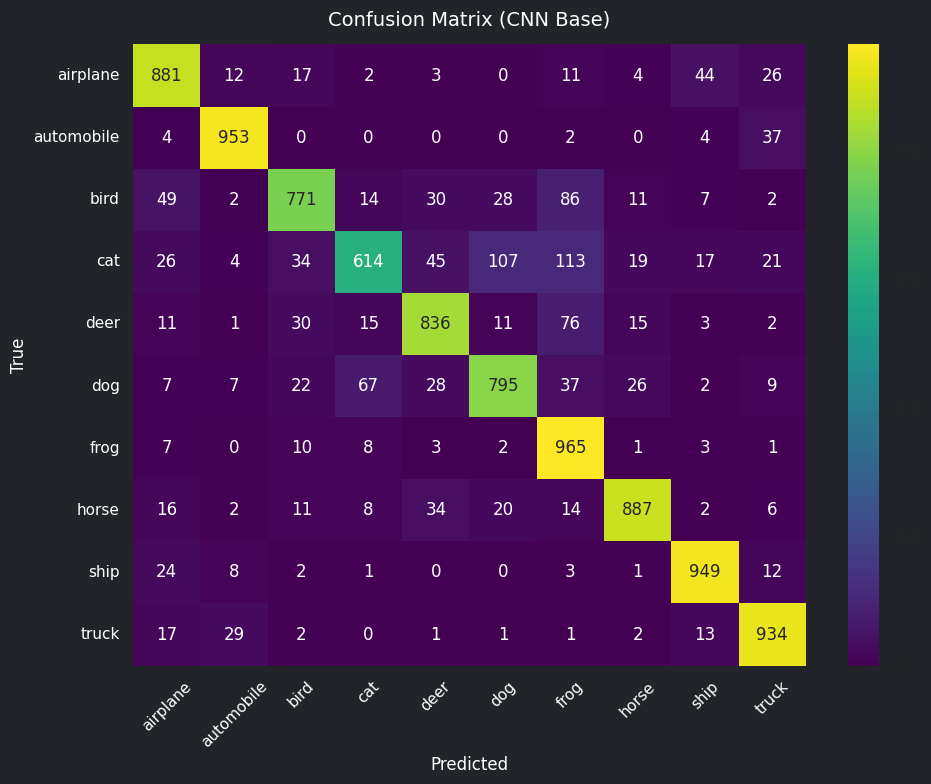

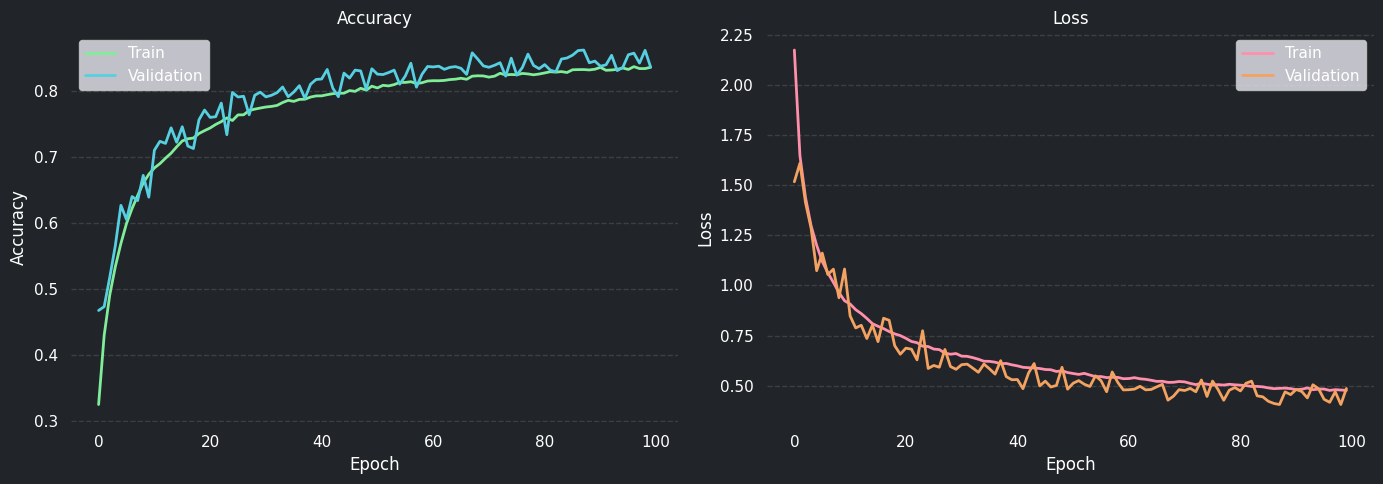

In [16]:
# Detailed report using reusable utils
y_true, y_pred = predict_and_resolve_labels(model=model, data=test_generator, verbose=0)

print("Classification Report:")
print(build_classification_report(y_true, y_pred))

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
cm = compute_confusion_matrix(y_true, y_pred)
plot_confusion_matrix_notebook01(
    confusion=cm,
    class_names=class_names,
    title='Confusion Matrix (CNN Base)',
    save_path=os.path.join(REPORTS_DIR, 'confusion.png'),
)

plot_training_curves_notebook01(
    history=history,
    save_path=os.path.join(REPORTS_DIR, 'curves.png'),
)

In [ ]:
# Save model
model_path = os.path.join(MODELS_DIR, 'vgg_bn_best_85.keras')
model.save(model_path)
print("✅ Saved Model:", model_path)

# Quick test confirmation
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Confirm: Test acc = {test_acc:.4f}")

# Reusable experiment logging
performance_report_path = os.path.join(DATA_DIR, 'model_performance_report.csv')
row = evaluate_and_log_model(
    model=model,
    model_name='CNN - VGG-like Base',
    data=test_generator,
    csv_path=performance_report_path,
    history=history,
    train_time_sec=train_duration_sec if 'train_duration_sec' in globals() else None,
    average='macro',
    verbose=0,
    extra_fields={'test_loss': float(test_loss)},
)
print('Logged metrics:', row)


✅ Saved Model: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/vgg_bn_best_85.keras
Confirm: Test acc = 0.8585
Logged metrics: {'model_name': 'CNN - VGG-like Base', 'num_params': 668842, 'train_time_sec': None, 'timestamp': '2026-02-18 23:32', 'accuracy': 0.8585, 'precision': 0.8613772698035232, 'recall': 0.8584999999999999, 'f1': 0.856199178465799, 'support': 10000, 'final_accuracy': 0.835099995136261, 'final_loss': 0.4769291579723358, 'final_val_accuracy': 0.8353365659713745, 'final_val_loss': 0.48633310198783875, 'final_learning_rate': 0.0003000000142492354, 'epochs_trained': 100, 'test_loss': 0.4205363690853119}
